# Object Placement Guide

This guide explains how to position objects in a simulation scene in FDTDX. The basic workflow looks like this: 1. Define a Simulation volume 2. Define objects and sizing/placement constraints between objects 3. Compute the actual position of objects in the simulation scene by using the place_objects function 4. Optional, but recommend: Plot the simulation scene using plot_setup() 5. Run a simulation

## Basic Positioning

In FDTDX, objects are positioned either directly or relation to other objects through constraints.

The first step should always be to define the size of the simulation volume. FDTDX always uses metrical units, i.e. meters or grid positions referring to the Yee-grid, which depends on the resolution used.

In [20]:
from fdtdx import SimulationConfig, SimulationVolume

# create a simulation config
config = SimulationConfig(
    time=200e-15,
    resolution=100e-9
)
# Create a simulation volume
volume = SimulationVolume(
    partial_real_shape=(4e-6, 4e-6, 1.5e-6),
)

We can already use the place_objects and plot_setup function to see the simulation volume.

In [6]:
import jax, fdtdx
import jax.numpy as jnp
from fdtdx import place_objects, plot_setup, SimulationConfig, SimulationVolume

# create a simulation config
config = SimulationConfig(
    time=200e-15,
    resolution=100e-9
)
# Create a simulation volume
volume = SimulationVolume(
    partial_real_shape=(4e-6, 4e-6, 1.5e-6),
)

key = jax.random.PRNGKey(seed=42)  # random key
# place objects and resolve constraints
objects, arrays, params, config, info = place_objects(
    volume=volume,
    config=config,
    constraints=[],
    key= key,
)
# plot the simulation scene
fig = plot_setup(
    config=config,
    objects=objects,
)
fig.savefig("empty_scene.png")

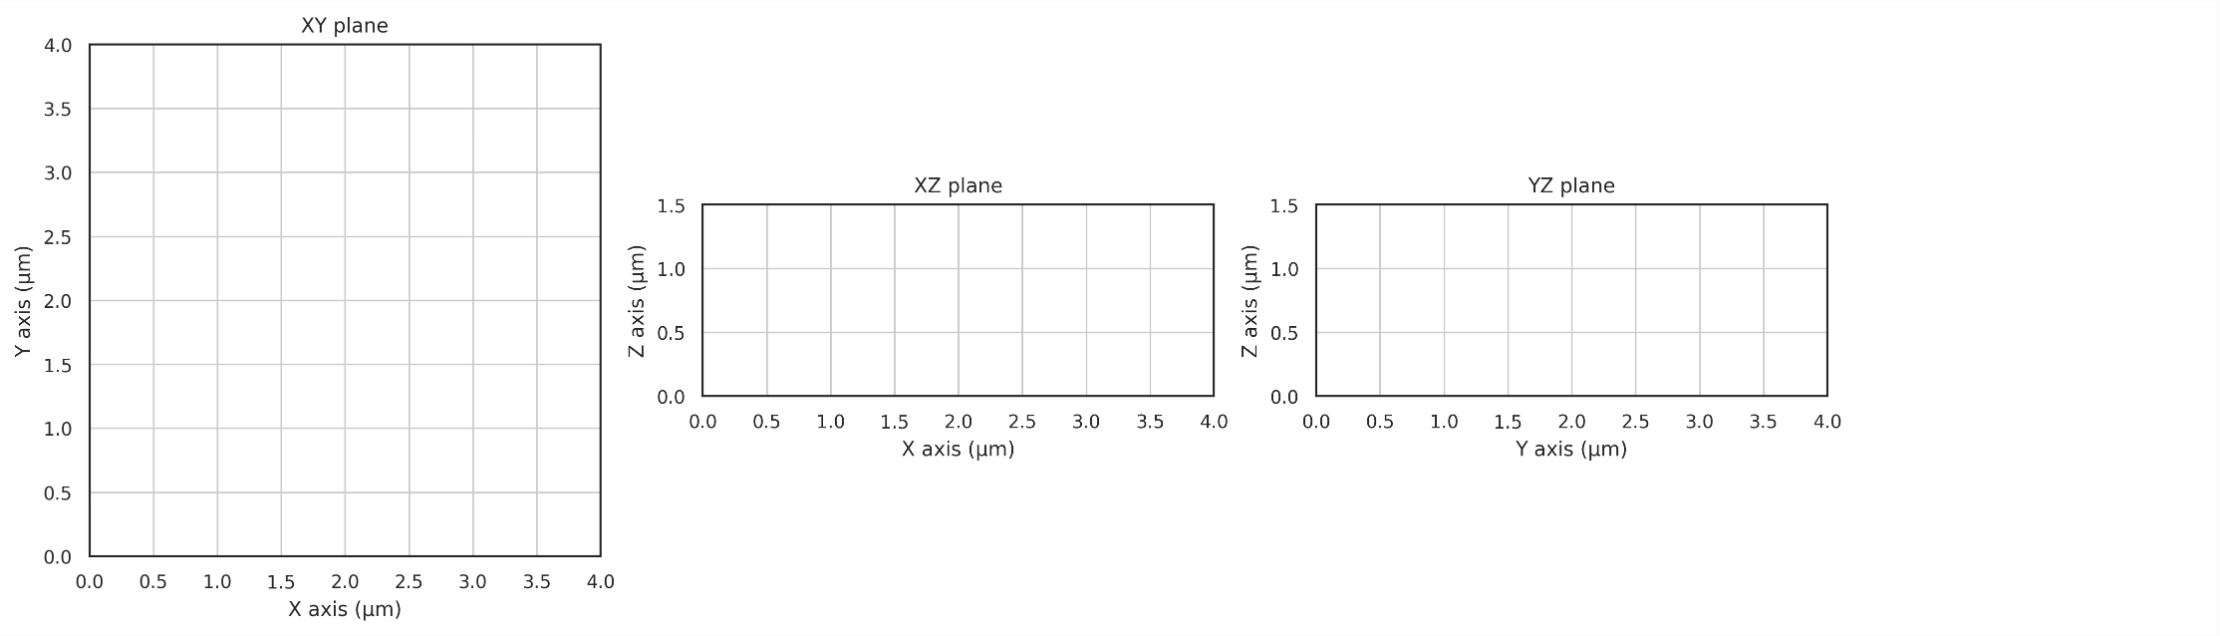

Now, we can start to position some objects in the simulation scene. We start with a substrate at the bottom of simulation. To this end, we specify a constraint that aligns the objects in the z-axis (axis 2). The user should specify these constraints and collect them in a list.

Positional constraints define an anchor point for both objects, which are constrainted to be at the same position. The position of the anchor point can be specified in a relative coordinate system of each object. A relative coordinate system means that a position of -1 would place the anchor at the left boundary of the object, a position of 0 at the middle and a position of 1 at the right boundary.

In case of the substrate, we want the lower boundary of the substrate to be aligned with the lower boundary of the simulation volume. This ensures that the substrate is placed exactly at the bottom of the simulation.

In [8]:
from fdtdx import Material, constants, UniformMaterialObject

# create list of constraints
placement_constraints = []
# create substrate
substrate = UniformMaterialObject(
    partial_real_shape=(None, None, 0.6e-6),
    material=Material(permittivity=constants.relative_permittivity_silica),
)
# place at the bottom of simulation volume
constraint = substrate.place_relative_to(
    volume,
    axes=2,
    own_positions=-1,
    other_positions=-1,
    margins=0,
    grid_margins=0,
)
placement_constraints.append(constraint)

The margins and grid_margins arguments are optional and would allow to speficy a fixed distance between the anchor points. The margins argument is in units of meters, the grid margins in units of yee-grid cells. Plotting this again results in

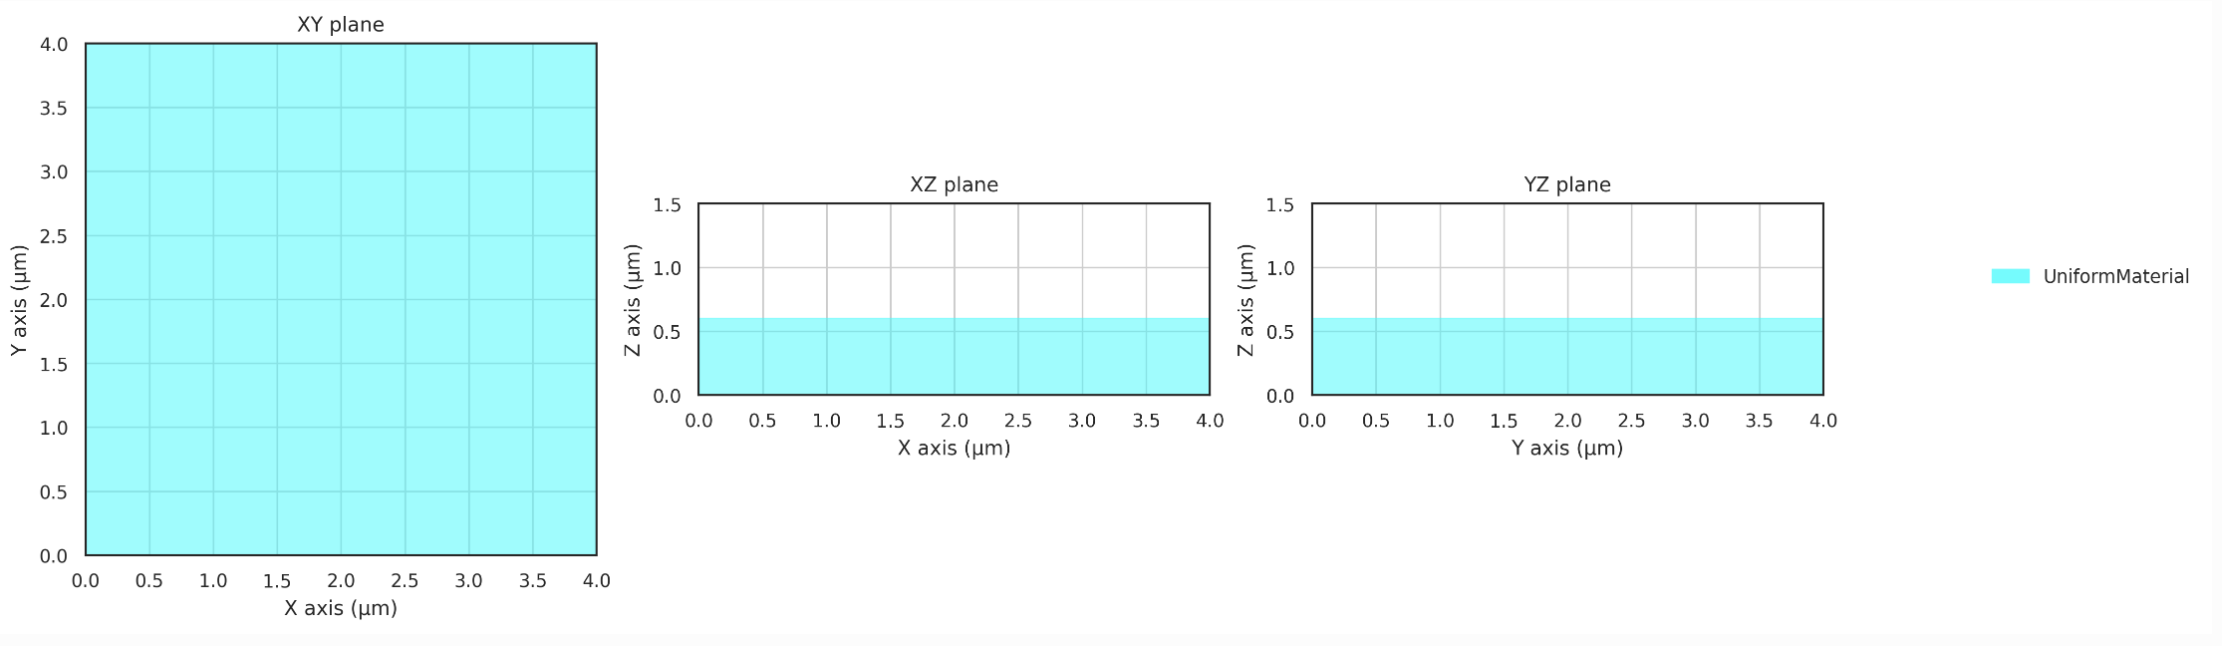

There exist a number of useful shorthands for rapid placements. Some of them are listed below that place a cube in the scene. The name and colors argument are only used for plotting.

In [ ]:
# place an object on top (z-axis / 2) of another object
cube1 = UniformMaterialObject(
    name="cube",
    color=colors.GREEN,
    partial_real_shape=(0.5e-6, 0.5e-6, 0.5e-6),
    material=Material(permittivity=constants.relative_permittivity_silicon),
)
placement_constraints.append(
    cube1.place_above(substrate)
)

# place an object at the center of another object
placement_constraints.append(
    cube1.place_at_center(
        substrate,
        axes=(0, 1),
    )
)

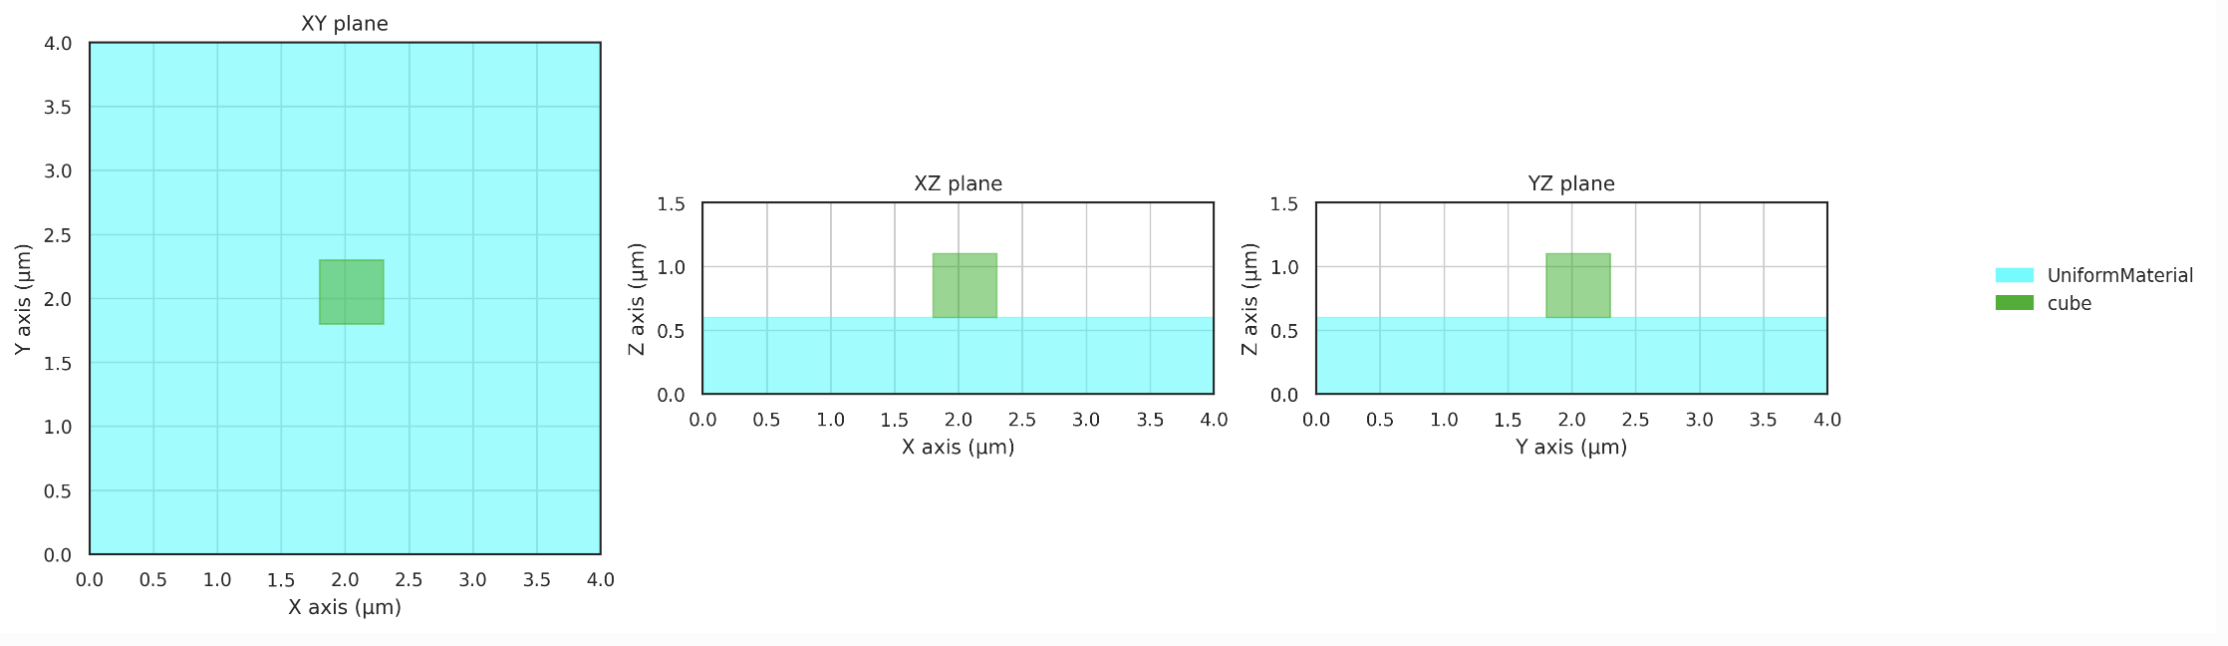

## Size Configuration

Object sizes can be specified in a number of ways. Firstly, one can directly set the size of an object in the init method. This can either be a specified in Yee-grid cells or metrical units (meter).

In [ ]:
# size in meters
cube = UniformMaterialObject(
    partial_real_shape=(0.3e-6, 1.0e-6, 0.7e-6),
    ...
)

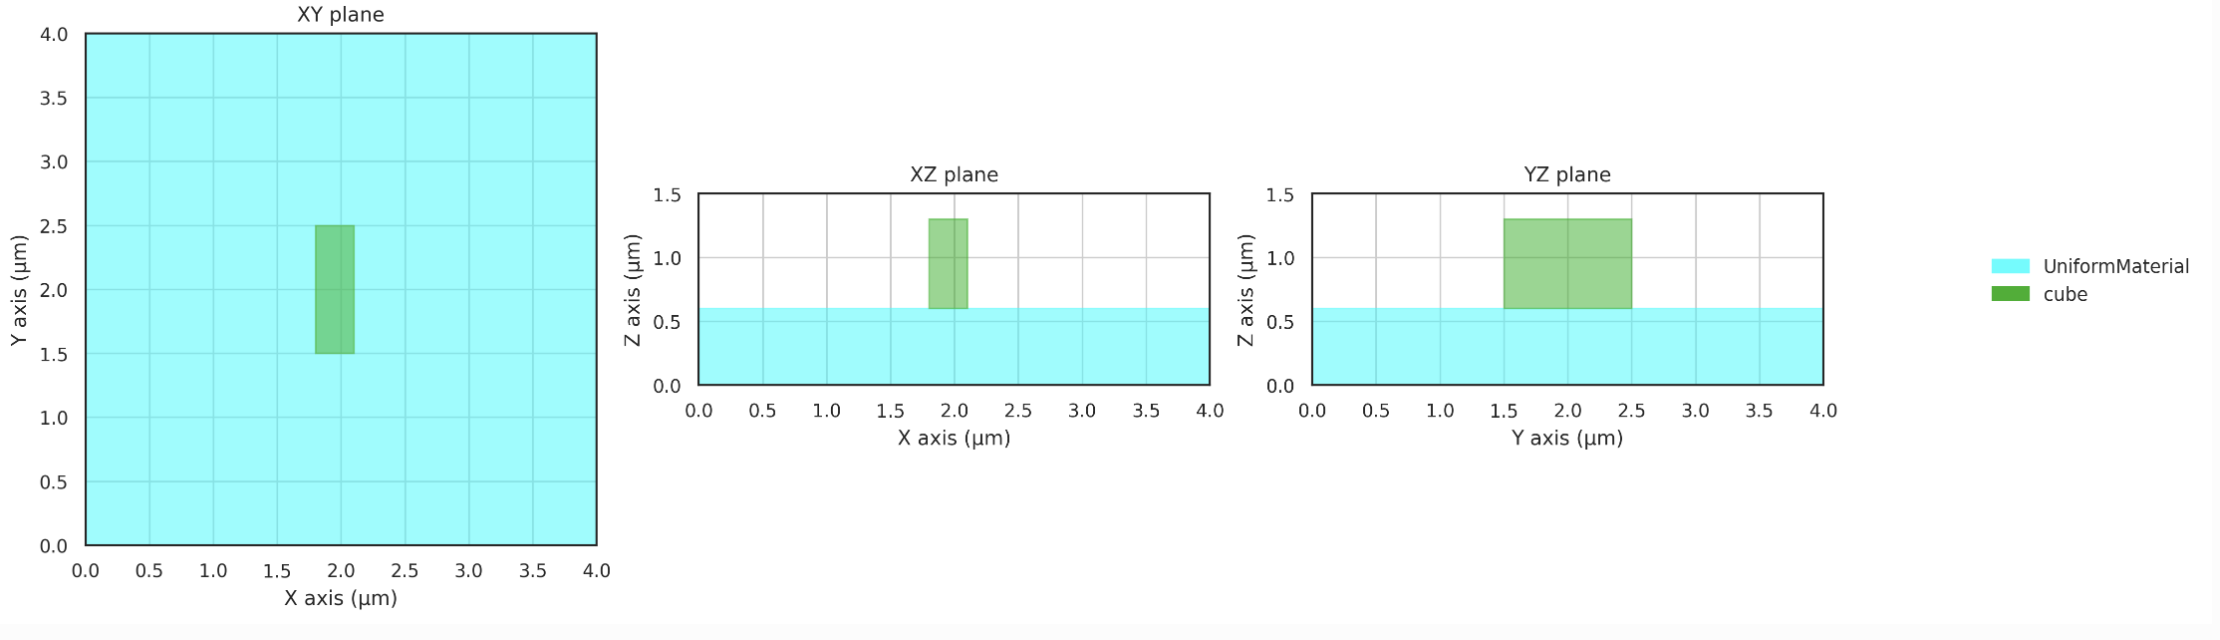

## Size in grid units

In [ ]:
# size in grid units (each 100nm as defined in config above)
cube = UniformMaterialObject(
    partial_grid_shape=(4, 10, 2),
    ...
)

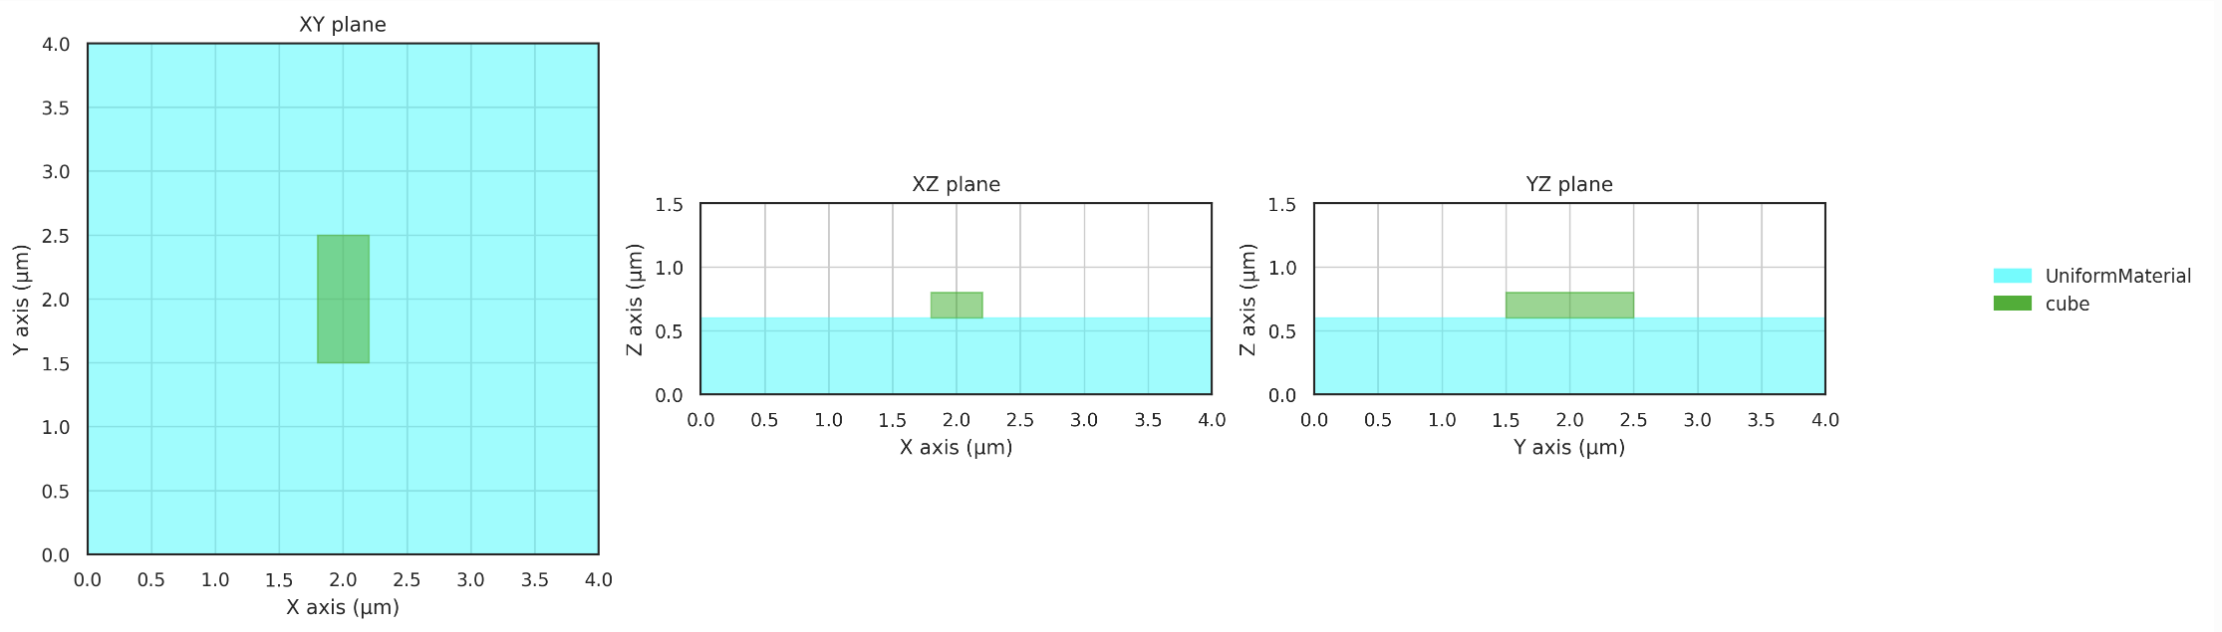

## Combination of grid and metrical units

In [ ]:
# partial combination
cube = UniformMaterialObject(
    partial_real_shape=(None, 0.5e-6, None),
    partial_grid_shape=(3, None, 1),
    ...
)

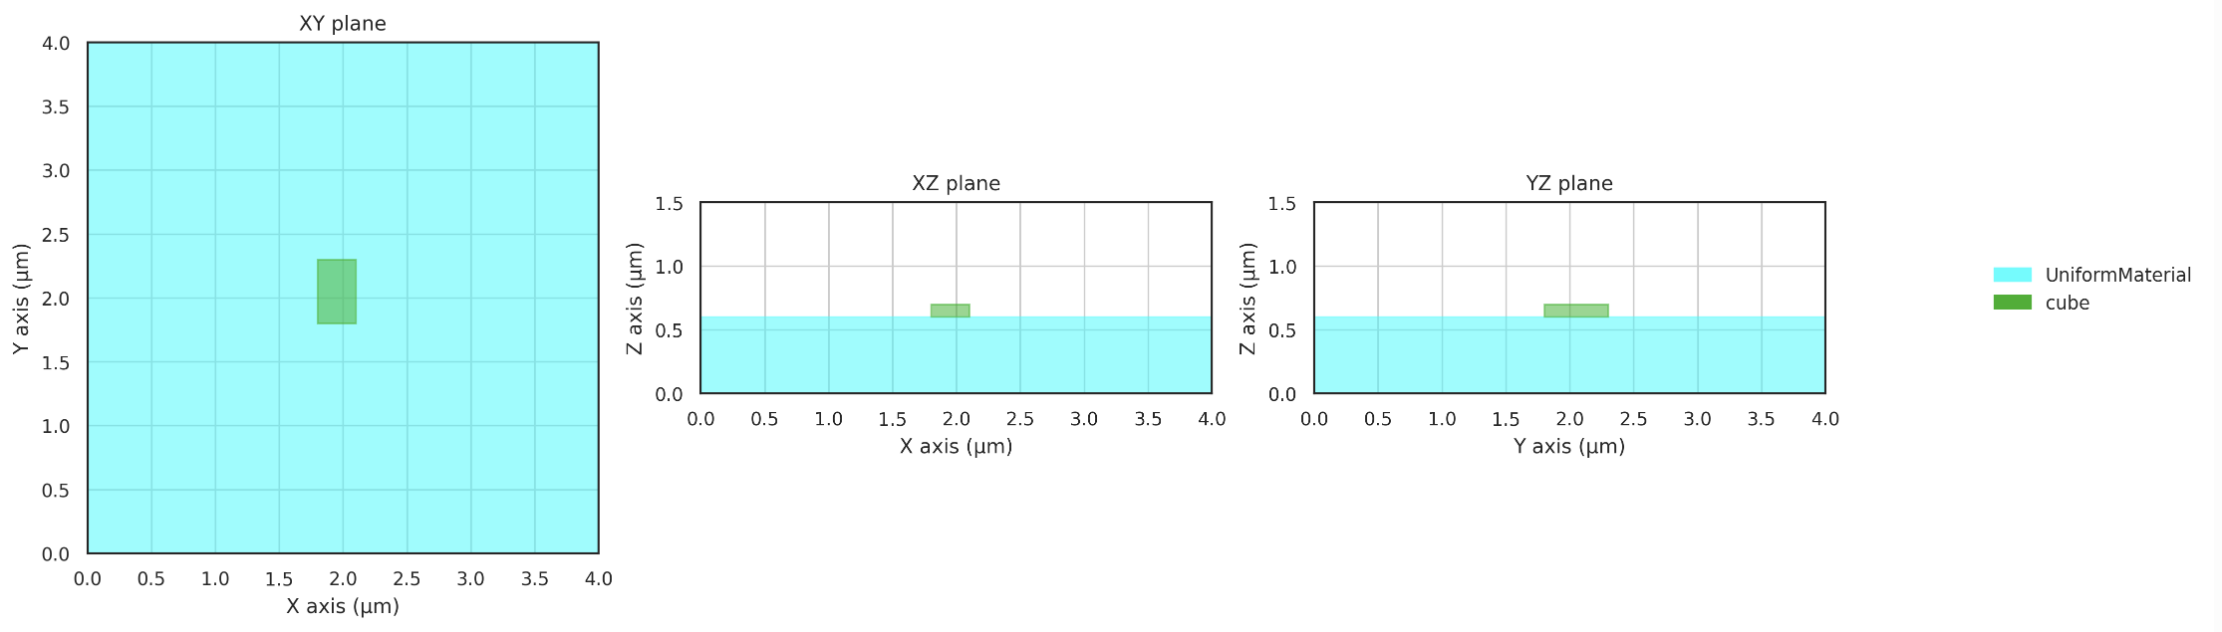

## Undefined Sizes can be useful

If the size of an object is only partially defined and does not have any constraints, the size is set to the size of the simulation volume in the respective axis. We actually already used this behavior to define the substrate above.

In [ ]:
# z-axis is undefined, size is extended to simulation size
cube = UniformMaterialObject(
    partial_real_shape=(None, 0.5e-6, None),
    partial_grid_shape=(3, None, None),
    ...
)
# This now results in an error:
placement_constraints.append(
    cube1.place_above(substrate)
)

Using this specification for the cube, we get the following error:

In [ ]:
Exception: Inconsisten grid shape (may be due to extension to infinity) at lower bound: 0 != 6 for axis=2, cube (<class 'fdtdx.objects.material.UniformMaterialObject'>). Object has a position constraint that puts the lower boundary at 6, but the lower bound was alreay computed to be at 0. This could be due to a missing size constraint/specification, which resulted in an expansion of the object to the simulation boundary (default size) or another constraint on this object.

The error occurs, because we tried to place the cube above the substrate, which is no longer possible if the z-size of the cube is the whole simulation size. When we remove the problematic placement constraint, we get the correct simulation scene.

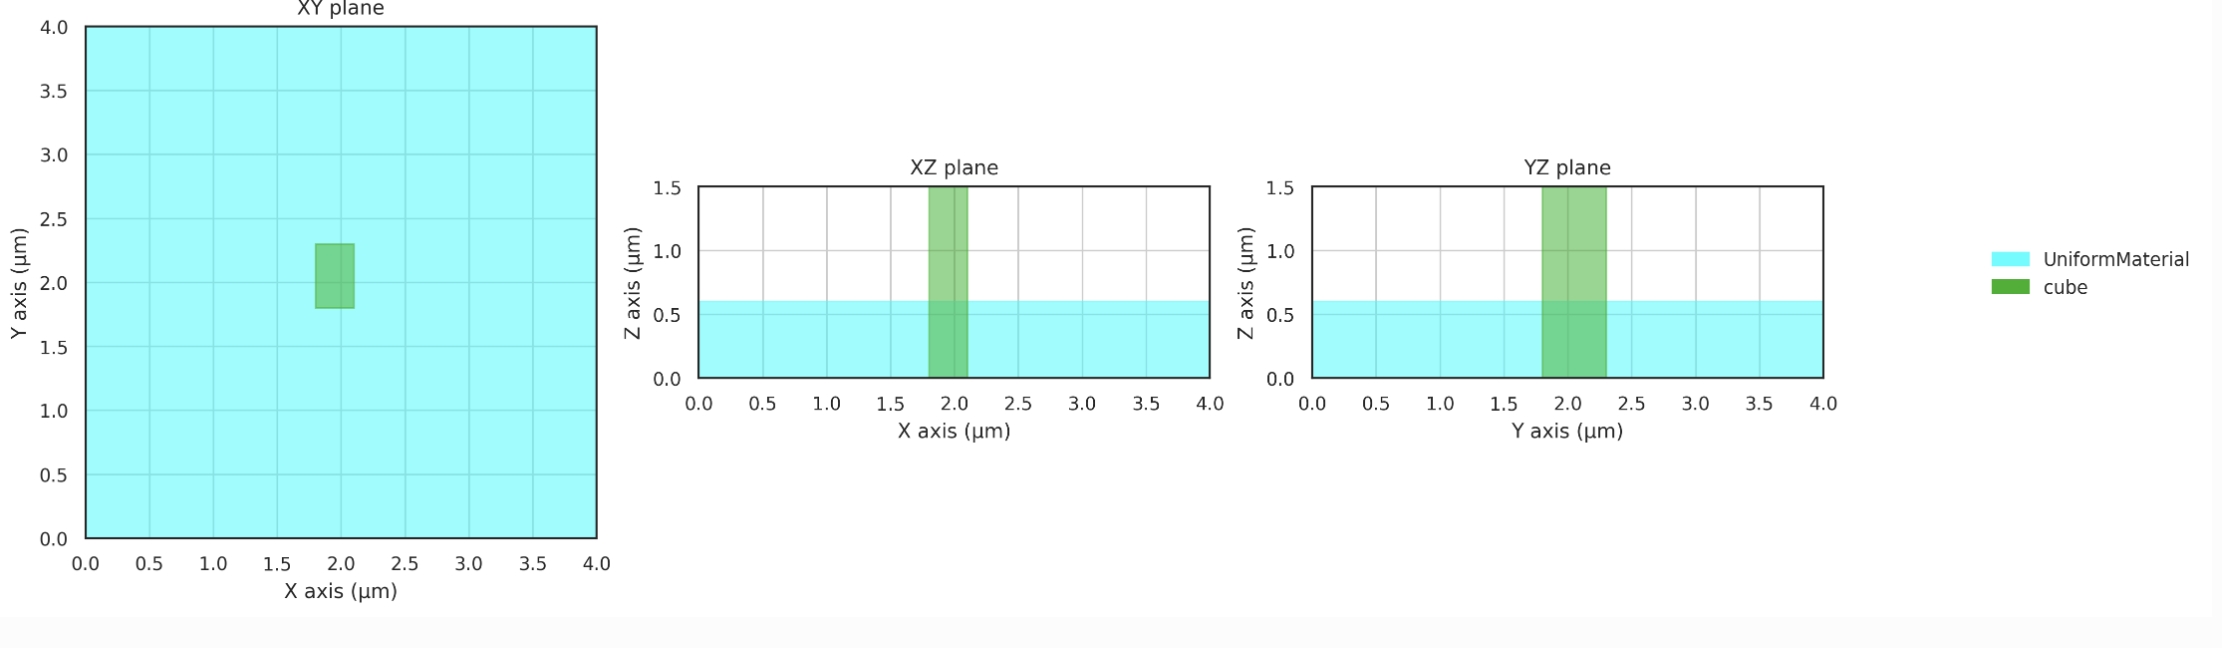

## Relative Sizing constraint

The size of an object can also be set in relation to another object. To demonstrate this, we define a second cube, which should be placed above the substrate and have a 200nm distance to the other cube in the x-axis.

In [ ]:
cube2 = UniformMaterialObject(
    name="cube2",
    color=colors.GREEN,
    partial_real_shape=(0.5e-6, 0.5e-6, 0.5e-6),
    material=Material(permittivity=constants.relative_permittivity_silicon),
)
placement_constraints.extend([
    cube2.place_above(substrate),
    cube2.place_relative_to(
        cube1,
        axes=(0, 1),
        own_positions=(1, 0),
        other_positions=(-1, 0),
        margins=(-200e-9, 0)
    )
])

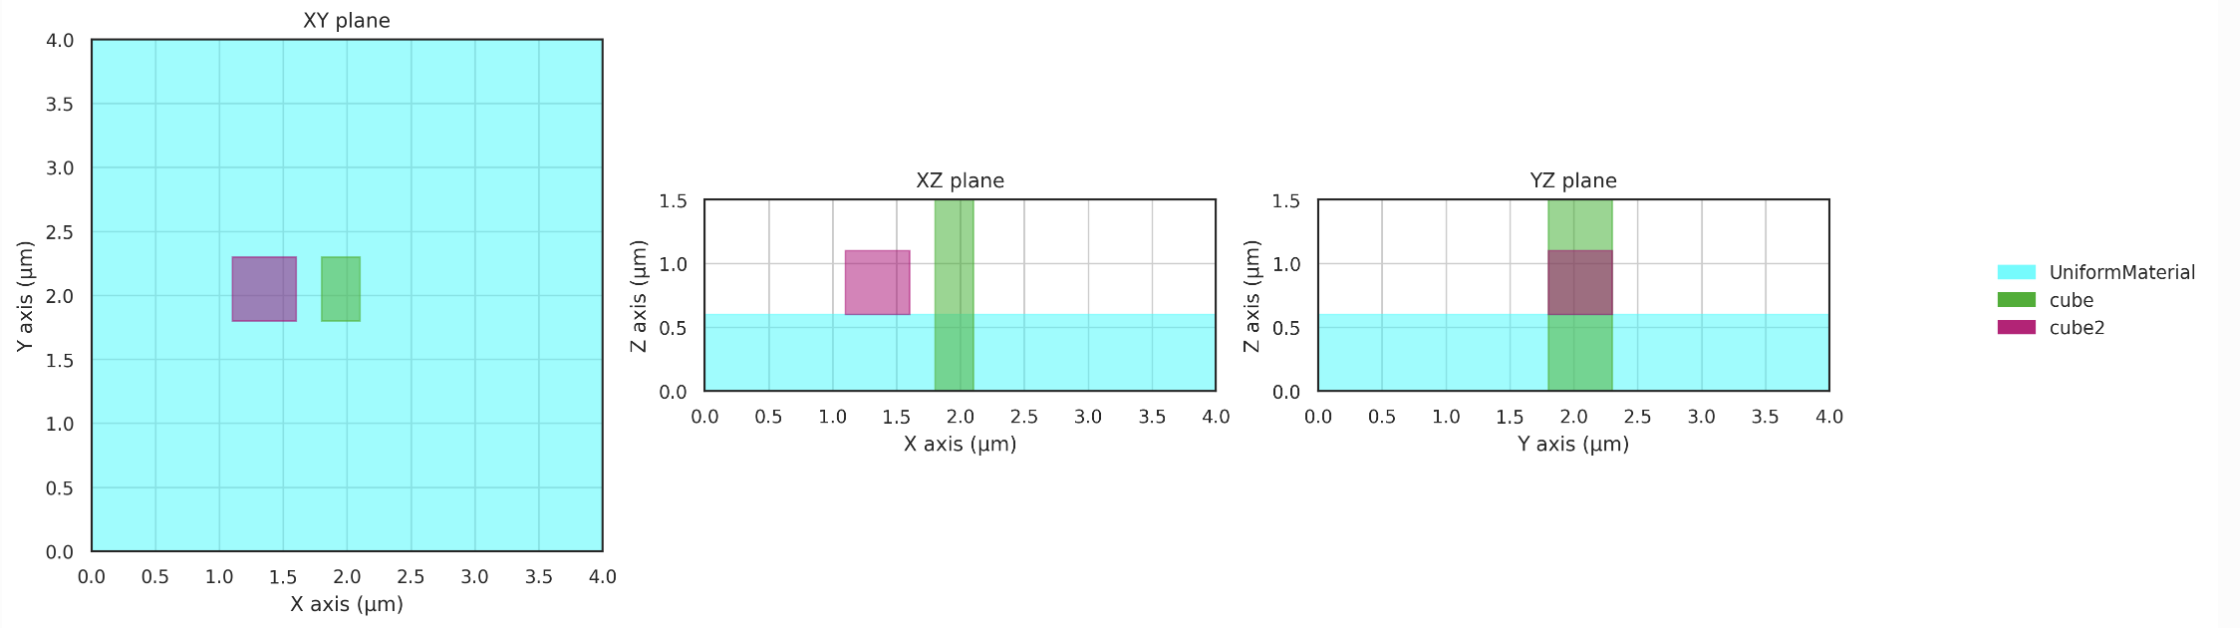

Now let's change the size definition of the second cube to a relative size constraint, which defines the y-size of the second cube as the size of the first cube in the z-axis.

In [ ]:
cube2 = UniformMaterialObject(
    name="cube2",
    color=colors.GREEN,
    partial_real_shape=(0.5e-6, None, 0.5e-6),
    material=Material(permittivity=constants.relative_permittivity_silicon),
)
placement_constraints.append(
    cube2.size_relative_to(
        cube1,
        axes=1,
        other_axes=2,
        proportions=1.0,
    )
)

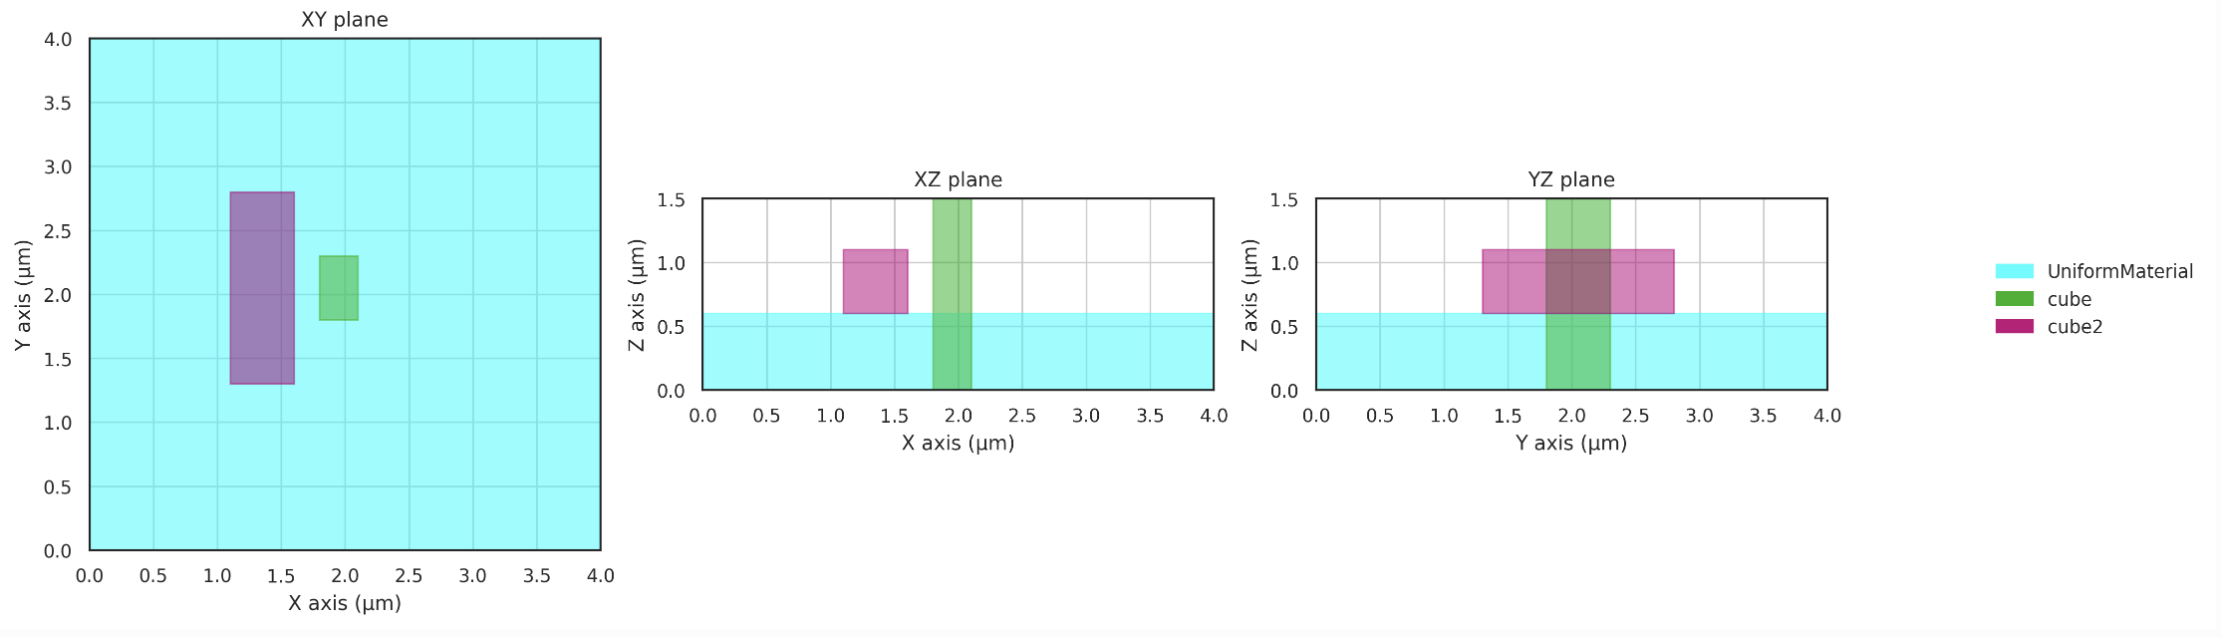

Another useful convenience wrapper is the following:

In [ ]:
object1.same_size(object2, axes=(0,1))

## Extending objects to other objects or Simulation boundaries

The last method to set the size of an object is to constrain the size, such that it extends up to another object in the simulation scene.

In [ ]:
# definition of first cube
cube1 = UniformMaterialObject(
    partial_real_shape=(0.5e-6, 0.5e-6, 0.5e-6),
    name="cube",
    color=colors.GREEN,
    material=Material(permittivity=constants.relative_permittivity_silicon),
)
placement_constraints.append(
    cube1.place_above(substrate)
)
placement_constraints.append(
    cube1.place_at_center(
        substrate,
        axes=(0, 1),
    )
)
cube2 = UniformMaterialObject(
    name="cube2",
    color=colors.MAGENTA,
    partial_real_shape=(None, 0.5e-6, 0.5e-6),
    material=Material(permittivity=constants.relative_permittivity_silicon),
)
placement_constraints.extend([
    cube2.place_above(substrate),
    # place at center of y-axis
    cube2.place_at_center(
        cube1,
        axes=1,
    ),
    # extend object up to first cube
    cube2.extend_to(
        cube1,
        axis=0,
        direction="+",
    )
])

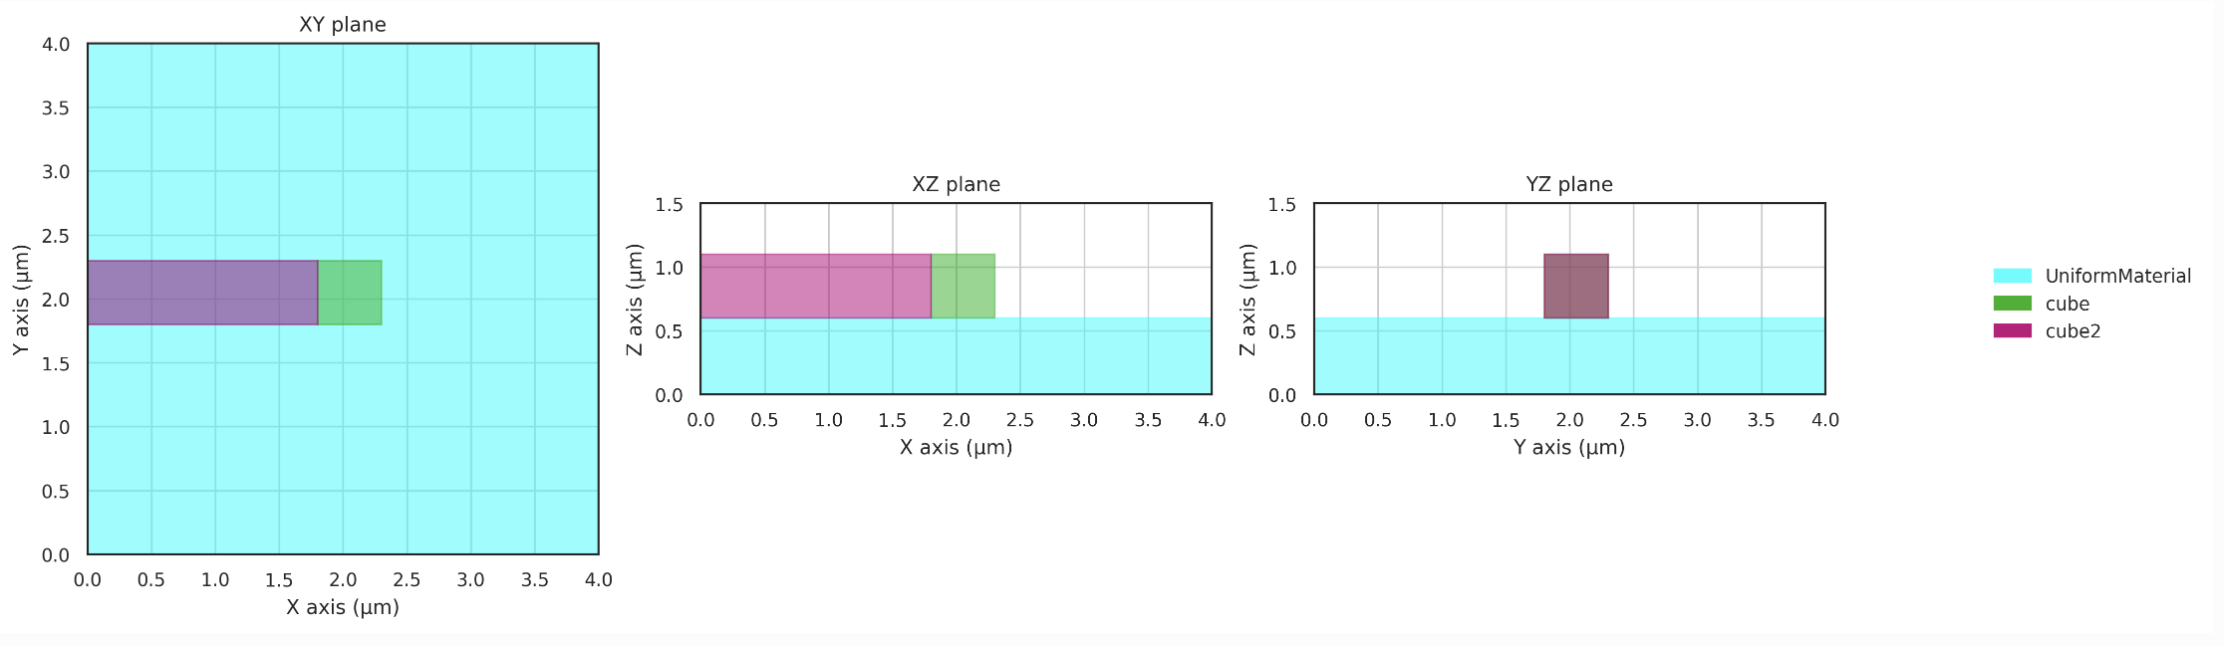

This constrains the size of cube2 such that its upper boundary ("+") extends directly up to cube1 in the x-axis.

See the Objects API Reference for complete details on all positioning and sizing options.